In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
from capstone_library import *
from scipy.stats import norm

# Hints
## Searching for Contamination Sources
This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

# Let's go!

Let's load the data.

In [21]:
X = np.load('initial_data/function_1/initial_inputs.npy')
Y = np.load('initial_data/function_1/initial_outputs.npy')

In [22]:
# loading new data
new_queries = get_function_data_from_file('new_data/queries.txt', 1)
new_observ = get_function_data_from_file('new_data/observations.txt', 1)

In [23]:
new_queries = np.array(new_queries).reshape(-1, 2)
new_observ = np.array(new_observ).reshape(-1)

In [24]:
# merging new data
X = np.concatenate((X, new_queries), axis=0)
Y = np.concatenate((Y, new_observ), axis=0)

## Visualizing the data and thinking of the problem

In [25]:
# visualising the data as a table
df = pd.DataFrame(np.hstack((X, Y.reshape(-1, 1))), columns=['x1', 'x2', 'y'])
df.head(100)

,x1,x2,y
0,0.319404,0.762959,1.322677e-79
1,0.574329,0.879898,1.033078e-46
2,0.731024,0.733000,7.710875e-16
3,0.840353,0.264732,3.341771e-124
4,0.650114,0.681526,-3.606063e-03
5,0.410437,0.147554,-2.159249e-54
6,0.312691,0.078723,-2.089093e-91
7,0.683418,0.861057,2.535001e-40
8,0.082507,0.403488,3.606771e-81
9,0.883890,0.582254,6.229856e-48


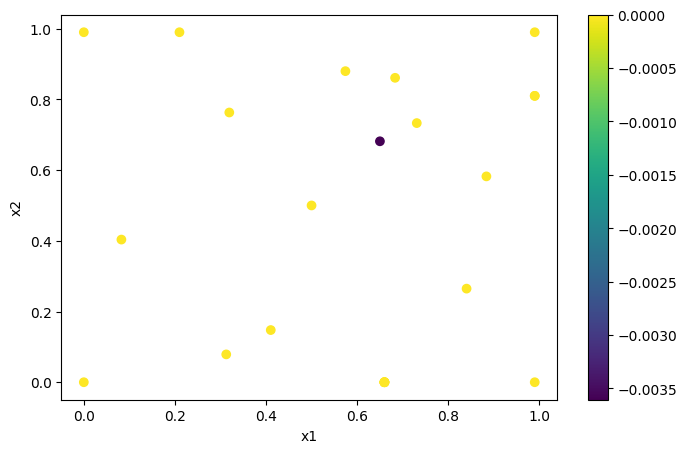

In [26]:
# visualising the data as a scatter plot
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Let's start with Bayesian Optimization with an Upper Confidence Bound acquisition function that uses a Gaussian Process as a surrogate model.
Given the radial nature of the problem (assuming that the radiation intensity is only function of the distance to the source) the default RBF kernel should be a good choice.

In [27]:
def get_next_query(kappa, X, Y):
    # parameters for the gaussian process
    gpr = GaussianProcessRegressor() # the default kernel is the RBF kernel
    gpr.fit(X, Y)

    # to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
    x1 = np.linspace(0, 1, 100, endpoint = False)
    x2 = np.linspace(0, 1, 100, endpoint = False)

    X_grid = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            X_grid.append([x1[i], x2[j]])

    X_grid = np.array(X_grid)

    mean, std = gpr.predict(X_grid, return_std = True)
    ucb = mean + kappa * std

    idx_max = np.argmax(ucb)
    next_query = X_grid[idx_max]
    return next_query, X_grid, ucb


In [28]:
# testing the function
next_query, X_grid, ucb = get_next_query(5, X, Y)
print(format_query(next_query))

0.860000-0.000000


Not sure why the acquisition function is so high on the edge. Maybe it's because there are a few negative observations in the middle.  
Let's plot the acquisition function.

In [29]:
def plot_acquisition_function(X_grid, ucb, next_query=None):
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    plt.scatter(X_grid[:, 0], X_grid[:, 1], c = ucb)
    if next_query is not None:
        plt.scatter(next_query[0], next_query[1], c = 'r', marker = 'x')
    plt.colorbar()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Acquisition function')
    plt.show()

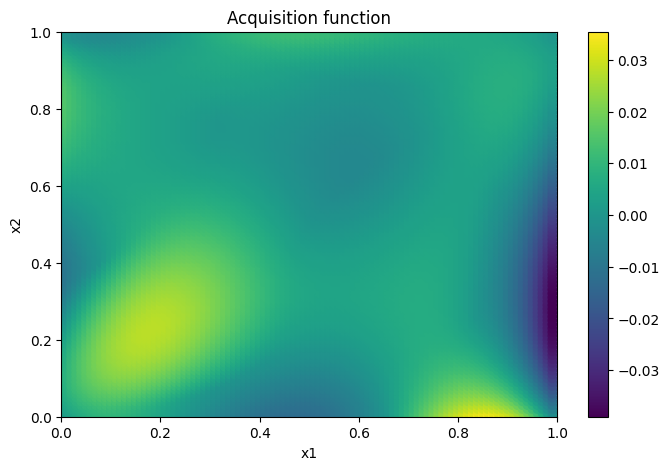

In [30]:
plot_acquisition_function(X_grid, ucb)

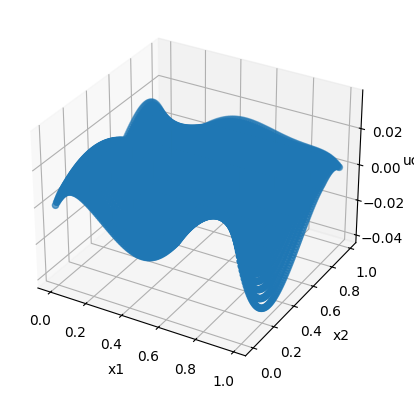

In [31]:
# plotting the acquisition function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_grid[:, 0], X_grid[:, 1], ucb)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('ucb')
plt.show()

 ### Observations with original data
All data points are very close to 0. The local minimum is at [0.65, 0.68], where the function is -3.6e-03.
Also, we can see that the function changes dramatically (in relative terms) around [0.7, 0.7], where it goes from  -3e-03 to 7e-16.
Those values are still very close to zero, but without knowing the range of the function in the maximum, we can't tell if the change is significant or not.

### Observations after query 1
The first query suggested by the acquisition function is at [0, 0.99], so at one corner of the domain.
The returned observation is 0.
The acquisition function is now very high at the opposite corner, [0.99, 0], so let's use this as the second query.


Out of curiosity, let's see how the acquisition function changes if we add points at the suggested next_query, assuming that they do not strike gold.

In [32]:
kappa = 10 # I'll change this value over time
dummy_value = 0e-30

while False:
    next_query, X_grid, ucb = get_next_query(kappa, X, Y)
    print(format_query(next_query))

    plot_acquisition_function(X_grid, ucb, next_query)
    
    # appending a small value
    new_row = np.array(next_query)
    X = np.vstack([X, new_row])
    Y = np.append(Y, dummy_value)

    user_input = input("Press Enter to continue or 0 to exit...")
    if user_input == '0':
        break

It looks like all the points are very close to the edge, possibly because there are negative areas in the middle.

### 20th reading (10th query)  

Let's try being more exploitative and use a lower kappa value of 1
... (0.990000-0.810000), still near the edge!


### After observation 22 (12th query)

Yet again, another very small value, negative, -7.6e-115, for a query near the edge, [0.99, 0.81].

Something that could be observed is that there is no noise applied to the function as identical queries produce identical results.
This is clearly not the case in the real world, where a reading from a Geiger counter would be different every time.

It seems like the function is very flat, as expected, so the acquisition function doesn't have much to go on.
A possible approach at this point might be to use a random search, as the acquisition function is not very useful.

Let's go with [0.5, 0.5] as the next query, as it is the center of the domain.

In [33]:
print(format_query([0.5,0.5]))

0.500000-0.500000


### After observation 23 (13th query)  

We got 2.7e-9, which is a very small value, but not negative.

In [34]:
# sorting the data by decreasing output
df.sort_values(by=['y'], ascending=False, inplace=True)
df.head(100)

,x1,x2,y
22,0.500000,0.500000,2.675288e-09
2,0.731024,0.733000,7.710875e-16
7,0.683418,0.861057,2.535001e-40
1,0.574329,0.879898,1.033078e-46
9,0.883890,0.582254,6.229856e-48
0,0.319404,0.762959,1.322677e-79
8,0.082507,0.403488,3.606771e-81
3,0.840353,0.264732,3.341771e-124
14,0.660000,0.000000,4.362046e-164
16,0.660000,0.000000,4.362046e-164


We seem to have found a (local) maximum (although still very small). With only a few queries left, let's get exploitative and hope that we are in the right area.

In [35]:
next_query, X_grid, ucb = get_next_query(0, X, Y)
print(format_query(next_query))

0.860000-0.000000


It looks like the acquisition function is still pushing us to enquire around the edges of the domain. This is because the GP is still very uncertain about the values in those regions.
Let's change approach and use the EI acquisition function instead. 

In [36]:
def get_next_query_EI(X, Y):
    # parameters for the gaussian process
    gpr = GaussianProcessRegressor() # the default kernel is the RBF kernel
    gpr.fit(X, Y)

    # to optimize the acquisition function, we will simply use gridsearch over a space of 10,000 gridpoints
    x1 = np.linspace(0, 1, 100, endpoint=False)
    x2 = np.linspace(0, 1, 100, endpoint=False)

    X_grid = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            X_grid.append([x1[i], x2[j]])

    X_grid = np.array(X_grid)

    mean, std = gpr.predict(X_grid, return_std=True)
    y_best = np.max(Y)

    # Compute the Expected Improvement
    with np.errstate(divide='warn'):
        Z = (y_best - mean) / std
        ei = (y_best - mean) * norm.cdf(Z) + std * norm.pdf(Z)
        ei[std == 0.0] = 0.0

    idx_max = np.argmax(ei)
    next_query = X_grid[idx_max]
    return next_query, X_grid, ei

In [37]:
next_query, X_grid, ei = get_next_query_EI(X, Y)
print(format_query(next_query))

0.990000-0.270000


Still suggesting points near the edge, where I have been told we are not to look!
Let's go with [0.25,0.35]

In [38]:
print(format_query([0.25, 0.35]))

0.250000-0.350000
